# This code takes in a folder of .npz files containing spectrograms and groundtruth binary lables that indicate if the recording has song or not. This code calcultes the recordings log-amplitudes, z-scored amplitude, and periodicity, saves the values in a .json file, then graphs a scatterplot color-coded by if the time bin contains song or note.

### Note that periodicity and amplitude are on different timescales, so this code interpolates to equalize the sampling rates between the two values.

## Generate the .json file containing periodicity calculations:

In [ ]:
#!/usr/bin/env python3
"""
Batch extractor for ground‑truth song intervals + modulation‑band power
----------------------------------------------------------------------

Paste your folder path into FOLDER_PATH and run this cell.
It scans every .npz file, extracts
    • smoothed 5–50 Hz modulation‑band power
    • ground‑truth song intervals from the stored `song` mask
and saves <folder name>_groundtruth_modband.json next to the folder.
"""

from pathlib import Path
import json
import numpy as np
from scipy.signal import spectrogram
from scipy.ndimage import gaussian_filter1d
from typing import Union, Optional, List, Dict  # ← classic typing helpers

# ─────────────────────────────────────────────
def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray) -> List[List[float]]:
    """Boolean mask → list of [start, stop] intervals in seconds."""
    padded = np.concatenate(([False], mask, [False]))
    diff   = np.diff(padded.astype(int))
    starts = np.where(diff ==  1)[0]
    stops  = np.where(diff == -1)[0]
    return [[float(times[s]), float(times[e-1])]  # e‑1 = last True index
            for s, e in zip(starts, stops)]


def process_npz(npz_path: Path) -> Optional[Dict]:
    """Return a JSON‑ready dict for one .npz file or None if keys missing."""
    with np.load(npz_path, allow_pickle=True) as npz:
        if NPZ_KEY_SPECTRO not in npz or NPZ_KEY_SONG_MASK not in npz:
            print(f"⚠️  {npz_path.name} missing required keys – skipped")
            return None

        S_db  = npz[NPZ_KEY_SPECTRO]              # shape = [freq, time]
        song  = npz[NPZ_KEY_SONG_MASK].astype(bool)
        n_freqs, n_times = S_db.shape

        # ---- time axis -------------------------------------------------
        if "t" in npz:
            time_axis = np.asarray(npz["t"], dtype=float)
            seg_dur   = time_axis[-1] + (time_axis[1] - time_axis[0])
        else:
            seg_dur   = SEGMENT_DURATION
            time_axis = np.linspace(0, seg_dur, n_times, endpoint=False)

        gt_intervals = mask_to_intervals(song, time_axis)

        # ---- log‑amplitude trace --------------------------------------
        S_lin   = 10 ** (S_db / 10)
        eps     = np.finfo(float).eps
        log_amp = np.log10(S_lin.sum(axis=0) + eps)

        # ---- envelope‑spectrogram & mod‑band power --------------------
        amp_fs  = len(time_axis) / seg_dur
        f_env, t_env, S_env = spectrogram(
            log_amp,
            fs=amp_fs,
            window="hann",
            nperseg=128,
            noverlap=96,
        )
        band    = (f_env >= MOD_LOW) & (f_env <= MOD_HIGH)
        raw_pow = S_env[band, :].sum(axis=0)
        smooth_pow = gaussian_filter1d(raw_pow, sigma=SMOOTHING_SIGMA)

        return {
            "file_name"             : npz_path.name,
            "mod_band_time"         : t_env.tolist(),
            "mod_band_power"        : smooth_pow.tolist(),
            "groundtruth_intervals" : gt_intervals,
        }


def process_folder(folder_path: Union[str, Path]) -> Path:
    """Process every valid .npz file in `folder_path` and write one JSON file."""
    folder = Path(folder_path).expanduser().resolve()
    if not folder.is_dir():
        raise NotADirectoryError(folder)

    records: List[Dict] = []
    for npz_file in sorted(folder.glob("*.npz")):
        if npz_file.name.startswith("._"):
            print(f"⚠️  Skipping macOS metadata file: {npz_file.name}")
            continue

        rec = process_npz(npz_file)
        if rec:
            records.append(rec)

    if not records:
        raise RuntimeError("No usable .npz files were found")

    out_modband_json = folder.with_name(f"{folder.name}_groundtruth_modband.json")
    with out_modband_json.open("w", encoding="utf‑8") as fh:
        json.dump(records, fh, indent=2)

    print(f"✅  Wrote {len(records)} entries → {out_modband_json}")
    return out_modband_json


    out_modband_json = folder.with_name(f"{folder.name}_groundtruth_modband.json")
    with out_modband_json.open("w", encoding="utf‑8") as fh:
        json.dump(records, fh, indent=2)

    print(f"✅  Wrote {len(records)} entries → {out_modband_json}")
    return out_modband_json


# ─────────────────────────────────────────────
# CONFIG – change only FOLDER_PATH if you like
# ─────────────────────────────────────────────
FOLDER_PATH = "/Volumes/my_own_SSD/UO_stuff/george_annotated_song/labeled_song_dataset/test"   # ← paste the folder path here

SEGMENT_DURATION = 10          # seconds if no 't' vector is stored
MOD_LOW, MOD_HIGH = 0, 50      # modulation‑frequency band (Hz)
SMOOTHING_SIGMA   = 3          # σ for Gaussian smoothing
NPZ_KEY_SPECTRO   = "s"
NPZ_KEY_SONG_MASK = "song"

# ─────────────────────────────────────────────
# Run the extractor
# ─────────────────────────────────────────────
process_folder(FOLDER_PATH)


## Generate the .json file containing the log-amplitude values:

In [ ]:
#!/usr/bin/env python3
"""
Batch saver: smoothed log‑amplitude trace + ground‑truth song mask
-----------------------------------------------------------------

For each .npz file in FOLDER_PATH this script:

1. Reconstructs a time axis (uses stored 't' if present, otherwise assumes the
   whole file spans SEGMENT_DURATION seconds).
2. Builds a log‑amplitude trace (log10 of the sum across frequency bins).
3. Smooths that trace with a Gaussian (σ = SMOOTHING_SIGMA samples).
4. Retrieves the ground‑truth 'song' mask.
5. Saves, for every file, a JSON record with:
      • file_name              : <file name>
      • log_amp_time           : list of time points (seconds)
      • smoothed_log_amp       : list of smoothed log‑amp values
      • song_mask              : list of 0/1 flags
      • groundtruth_intervals  : [[start, stop], …]   (seconds)

The JSON file is written one level **above** the .npz folder:
    <folder name>_logamp_groundtruth.json
"""

from pathlib import Path
import json
from typing import Union, Optional, List, Dict

import numpy as np
from scipy.ndimage import gaussian_filter1d

# ────────────────────────────────────────────────────────────────────
def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray) -> List[List[float]]:
    """Boolean mask → list of [start, stop] intervals (seconds)."""
    padded = np.concatenate(([False], mask, [False]))
    diff   = np.diff(padded.astype(int))
    starts = np.where(diff ==  1)[0]
    stops  = np.where(diff == -1)[0]
    return [[float(times[s]), float(times[e-1])] for s, e in zip(starts, stops)]


def process_npz(npz_path: Path) -> Optional[Dict]:
    """Return a JSON‑ready dict for one .npz file (None if keys missing)."""
    with np.load(npz_path, allow_pickle=True) as npz:
        if NPZ_KEY_SPECTRO not in npz or NPZ_KEY_SONG not in npz:
            print(f"⚠️  {npz_path.name} missing required keys – skipped")
            return None

        S_db  = npz[NPZ_KEY_SPECTRO]          # shape = (freq, time)
        song  = npz[NPZ_KEY_SONG].astype(bool)
        n_freqs, n_times = S_db.shape

        # ---- time axis -------------------------------------------------
        if "t" in npz:
            t = np.asarray(npz["t"], dtype=float)
            seg_dur = t[-1] + (t[1] - t[0])
        else:
            seg_dur = SEGMENT_DURATION
            t = np.linspace(0, seg_dur, n_times, endpoint=False)

        # ---- log‑amplitude trace --------------------------------------
        eps     = np.finfo(float).eps
        S_lin   = 10 ** (S_db / 10)           # dB → linear power
        log_amp = np.log10(S_lin.sum(axis=0) + eps)
        log_amp_sm = gaussian_filter1d(log_amp, sigma=SMOOTHING_SIGMA)

        return {
            "file_name"            : npz_path.name,
            "log_amp_time"         : t.tolist(),
            "smoothed_log_amp"     : log_amp_sm.tolist(),
            "song_mask"            : song.astype(int).tolist(),
            "groundtruth_intervals": mask_to_intervals(song, t),
        }


def process_folder(folder_path: Union[str, Path]) -> Path:
    """Process every valid .npz file in `folder_path` and write one JSON file."""
    folder = Path(folder_path).expanduser().resolve()
    if not folder.is_dir():
        raise NotADirectoryError(folder)

    records: List[Dict] = []
    for npz_file in sorted(folder.glob("*.npz")):
        if npz_file.name.startswith("._"):
            print(f"⚠️  Skipping macOS metadata file: {npz_file.name}")
            continue

        rec = process_npz(npz_file)
        if rec:
            records.append(rec)

    if not records:
        raise RuntimeError("No usable .npz files were found")

    out_modband_json = folder.with_name(f"{folder.name}_groundtruth_logamp.json")
    with out_modband_json.open("w", encoding="utf‑8") as fh:
        json.dump(records, fh, indent=2)

    print(f"✅  Wrote {len(records)} entries → {out_modband_json}")
    return out_modband_json

# ────────────────────────────────────────────────────────────────────
# CONFIG – edit only FOLDER_PATH unless you need different params
# ────────────────────────────────────────────────────────────────────
#FOLDER_PATH = "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs"   # ← paste your folder path here

SEGMENT_DURATION = 10          # seconds if no 't' vector stored
SMOOTHING_SIGMA  = 3           # Gaussian σ (samples) for log‑amp smoothing
NPZ_KEY_SPECTRO  = "s"
NPZ_KEY_SONG     = "song"
# ────────────────────────────────────────────────────────────────────
# Run the extractor
# ────────────────────────────────────────────────────────────────────
process_folder(FOLDER_PATH)


## Calculate the z-scored amplitude:

In [ ]:
#!/usr/bin/env python3
"""
Batch saver: smoothed **z‑scored amplitude** trace + ground‑truth song mask
--------------------------------------------------------------------------

For each .npz file in FOLDER_PATH this script:

1. Reconstructs a time axis (uses stored 't' if present, otherwise assumes the
   whole file spans SEGMENT_DURATION seconds).
2. Builds a linear‑amplitude trace (sum across frequency bins) and z‑scores it
   ((x‑μ)/σ).
3. Smooths the z‑scored trace with a Gaussian (σ = SMOOTHING_SIGMA samples).
4. Retrieves the ground‑truth 'song' mask.
5. Saves, for every file, a JSON record with:
      • file_name              : <file name>
      • z_amp_time             : list of time points (seconds)
      • smoothed_z_amp         : list of smoothed z‑scored amplitudes
      • song_mask              : list of 0/1 flags
      • groundtruth_intervals  : [[start, stop], …]   (seconds)

The JSON file is written one level **above** the .npz folder:
    <folder name>_zamp_groundtruth.json
"""

from pathlib import Path
import json
from typing import Union, Optional, List, Dict

import numpy as np
from scipy.ndimage import gaussian_filter1d

# ────────────────────────────────────────────────────────────────────
def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray) -> List[List[float]]:
    """Boolean mask → list of [start, stop] intervals (seconds)."""
    padded = np.concatenate(([False], mask, [False]))
    diff   = np.diff(padded.astype(int))
    starts = np.where(diff ==  1)[0]
    stops  = np.where(diff == -1)[0]
    return [[float(times[s]), float(times[e-1])] for s, e in zip(starts, stops)]


def process_npz(npz_path: Path) -> Optional[Dict]:
    """Return a JSON‑ready dict for one .npz file (None if keys missing)."""
    with np.load(npz_path, allow_pickle=True) as npz:
        if NPZ_KEY_SPECTRO not in npz or NPZ_KEY_SONG not in npz:
            print(f"⚠️  {npz_path.name} missing required keys – skipped")
            return None

        S_db  = npz[NPZ_KEY_SPECTRO]          # shape = (freq, time)
        song  = npz[NPZ_KEY_SONG].astype(bool)
        n_freqs, n_times = S_db.shape

        # ---- time axis -------------------------------------------------
        if "t" in npz:
            t = np.asarray(npz["t"], dtype=float)
            seg_dur = t[-1] + (t[1] - t[0])
        else:
            seg_dur = SEGMENT_DURATION
            t = np.linspace(0, seg_dur, n_times, endpoint=False)

        # ---- build z‑scored amplitude trace ---------------------------
        S_lin      = 10 ** (S_db / 10) if np.any(S_db < 0) else S_db
        amp_trace  = S_lin.sum(axis=0)                 # linear magnitude
        mu, sigma  = amp_trace.mean(), amp_trace.std()
        if sigma == 0:
            print(f"⚠️  {npz_path.name}: zero variance, skipped")
            return None
        z_amp      = (amp_trace - mu) / sigma
        z_amp_sm   = gaussian_filter1d(z_amp, sigma=SMOOTHING_SIGMA)

        return {
            "file_name"            : npz_path.name,
            "z_amp_time"           : t.tolist(),
            "smoothed_z_amp"       : z_amp_sm.tolist(),
            "song_mask"            : song.astype(int).tolist(),
            "groundtruth_intervals": mask_to_intervals(song, t),
        }


def process_folder(folder_path: Union[str, Path]) -> Path:
    """Process every valid .npz file in `folder_path` and write one JSON file."""
    folder = Path(folder_path).expanduser().resolve()
    if not folder.is_dir():
        raise NotADirectoryError(folder)

    records: List[Dict] = []
    for npz_file in sorted(folder.glob("*.npz")):
        if npz_file.name.startswith("._"):
            print(f"⚠️  Skipping macOS metadata file: {npz_file.name}")
            continue

        rec = process_npz(npz_file)
        if rec:
            records.append(rec)

    if not records:
        raise RuntimeError("No usable .npz files were found")

    out_modband_json = folder.with_name(f"{folder.name}_groundtruth_zamp.json")
    with out_modband_json.open("w", encoding="utf‑8") as fh:
        json.dump(records, fh, indent=2)

    print(f"✅  Wrote {len(records)} entries → {out_modband_json}")
    return out_modband_json

# ────────────────────────────────────────────────────────────────────
# CONFIG – edit only FOLDER_PATH unless you need different params
# ────────────────────────────────────────────────────────────────────
#FOLDER_PATH = "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs"  # ← paste your folder path

SEGMENT_DURATION = 10          # seconds if no 't' vector stored
SMOOTHING_SIGMA  = 3           # Gaussian σ (samples) for z‑amp smoothing
NPZ_KEY_SPECTRO  = "s"
NPZ_KEY_SONG     = "song"
# ────────────────────────────────────────────────────────────────────
# Run the extractor
# ────────────────────────────────────────────────────────────────────
process_folder(FOLDER_PATH)


## Combine all of the .json files into one file:

In [ ]:
from pathlib import Path
import json
from typing import Dict, List, Optional

# ── helper: load one JSON and index it by file_name ─────────────────────────
def _load_by_name(json_path: str) -> Dict[str, dict]:
    with open(json_path, "r", encoding="utf‑8") as fh:
        recs = json.load(fh)
    return {r["file_name"]: r for r in recs}

# ────────────────────────────────────────────────────────────────────────────
def combine_jsons(
    *json_paths: str,
    out_path: Optional[str] = None,
) -> Path:
    """
    Merge an arbitrary number of JSON summary files.

    Parameters
    ----------
    *json_paths : str
        One or more paths to JSON files.  Order matters: keys in later files
        override the same keys from earlier files when duplicates occur.
    out_path : str or None
        Where to write the combined JSON.  If None, a name is generated from
        the first input file (<prefix>_combined.json).

    Returns
    -------
    pathlib.Path
        Path to the written combined JSON.
    """
    if len(json_paths) < 2:
        raise ValueError("Provide at least two JSON paths to combine.")

    # -------- load each file into a dict{file_name: record} ---------------
    sources: List[Dict[str, dict]] = [_load_by_name(p) for p in json_paths]

    # -------- union of all file names -------------------------------------
    all_files = sorted(set().union(*(src.keys() for src in sources)))
    combined: List[dict] = []

    for fname in all_files:
        rec: dict = {"file_name": fname}

        # iterate over the source dicts *in the given order*
        for src in sources:
            if fname not in src:
                continue
            for key, val in src[fname].items():
                if key == "file_name":
                    continue
                # later files overwrite earlier ones
                rec[key] = val
        combined.append(rec)

    # -------- choose output path ------------------------------------------
    if out_path is None:
        first = Path(json_paths[0]).resolve()
        prefix = first.stem.split("_")[0]          # crude but practical
        out_path = str(first.with_name(f"{prefix}_combined.json"))

    with open(out_path, "w", encoding="utf‑8") as fh:
        json.dump(combined, fh, indent=2)

    print(f"✅  Combined {len(combined)} entries → {out_path}")
    return Path(out_path)


# ── Example call ───────────────────────────────────────────────────────────
combine_jsons(
    "/Volumes/my_own_SSD/UO_stuff/george_annotated_song/labeled_song_dataset/test_groundtruth_logamp.json",
    "/Volumes/my_own_SSD/UO_stuff/george_annotated_song/labeled_song_dataset/test_groundtruth_modband.json",
    "/Volumes/my_own_SSD/UO_stuff/george_annotated_song/labeled_song_dataset/test_groundtruth_zamp.json"
)


## Visualize the results:

## Periodicity vs. z-scored amplitude:

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ──────────────────────────────────────────────────────────────
# 1. Load the combined JSON file
COMBINED_JSON = Path(
    "/Volumes/my_own_SSD/UO_stuff/george_annotated_song/labeled_song_dataset/test_combined.json"
).expanduser().resolve()

records = json.loads(COMBINED_JSON.read_text(encoding="utf‑8"))
print(f"Loaded {len(records)} combined entries from {COMBINED_JSON.name}")

# ──────────────────────────────────────────────────────────────
# 2. Function to select amplitude source
def get_amp_arrays(rec: dict):
    """Return (time, value, label) for amplitude trace in a record."""
    if "z_amp_time" in rec and "smoothed_z_amp" in rec:
        return (rec["z_amp_time"], rec["smoothed_z_amp"],
                "Smoothed z‑score amplitude (interpolated)")
    if "log_amp_time" in rec and "smoothed_log_amp" in rec:
        return (rec["log_amp_time"], rec["smoothed_log_amp"],
                "Smoothed log‑amplitude (interpolated)")
    return None, None, None   # nothing usable

# ──────────────────────────────────────────────────────────────
# 3. Precompute global axis limits
temp_x_all, temp_y_all = [], []
for rec in records:
    amp_time, amp_vals, _ = get_amp_arrays(rec)
    if amp_time is None:
        continue

    t_amp  = np.asarray(amp_time, dtype=float)
    amp_sm = np.asarray(amp_vals, dtype=float)
    t_mod  = np.asarray(rec.get("mod_band_time", []), dtype=float)
    mod_pow = np.asarray(rec.get("mod_band_power", []), dtype=float)

    if t_amp.size == 0 or t_mod.size == 0:
        continue

    amp_interp = np.interp(t_mod, t_amp, amp_sm)
    temp_x_all.append(amp_interp)
    temp_y_all.append(mod_pow)

X_ALL = np.concatenate(temp_x_all)
Y_ALL = np.concatenate(temp_y_all)
dx = 0.05 * (X_ALL.max() - X_ALL.min() or 1)
dy = 0.05 * (Y_ALL.max() - Y_ALL.min() or 1)
X_MIN, X_MAX = X_ALL.min() - dx, X_ALL.max() + dx
Y_MIN, Y_MAX = Y_ALL.min() - dy, Y_ALL.max() + dy

# ──────────────────────────────────────────────────────────────
# 4. Prepare accumulators for pooled plot
all_x_song, all_y_song, all_x_nonsong, all_y_nonsong = [], [], [], []

# ──────────────────────────────────────────────────────────────
# 5. Plot each segment and collect for pooled scatter
for rec in records:
    fname = rec["file_name"]
    amp_time, amp_vals, x_label = get_amp_arrays(rec)
    if amp_time is None:
        print(f"⚠️  {fname}: no amplitude trace found – skipped")
        continue

    t_amp  = np.asarray(amp_time, dtype=float)
    amp_sm = np.asarray(amp_vals, dtype=float)
    t_mod  = np.asarray(rec.get("mod_band_time", []),  dtype=float)
    mod_pow = np.asarray(rec.get("mod_band_power", []), dtype=float)

    if t_amp.size == 0 or t_mod.size == 0:
        print(f"⚠️  {fname}: missing time axes – skipped")
        continue

    amp_interp = np.interp(t_mod, t_amp, amp_sm)

    in_song = np.zeros_like(t_mod, dtype=bool)
    for start, stop in rec.get("groundtruth_intervals", []):
        in_song |= (t_mod >= start) & (t_mod <= stop)

    # collect points
    all_x_song.append(amp_interp[in_song])
    all_y_song.append(mod_pow[in_song])
    all_x_nonsong.append(amp_interp[~in_song])
    all_y_nonsong.append(mod_pow[~in_song])

    # individual file plot
    plt.figure(figsize=(6, 5))
    plt.scatter(amp_interp[~in_song], mod_pow[~in_song],
                s=8, color="black", alpha=0.2, label="Non‑song")
    # plt.scatter(amp_interp[in_song], mod_pow[in_song],
    #             s=30, facecolor="yellow", edgecolor="black",
    #             linewidth=0.5, alpha=0.9, label="Ground‑truth song")
    plt.scatter(amp_interp[in_song], mod_pow[in_song],s=8, facecolor="orange", alpha=0.2, label="Ground‑truth song")
    plt.xlabel(x_label)
    plt.ylabel("Periodicity power")
    plt.title(fname, fontsize=9)
    plt.xlim(X_MIN, X_MAX)
    plt.ylim(Y_MIN, Y_MAX)
    plt.grid(False, lw=0.3, alpha=0.3)
    plt.legend(fontsize="x-small")
    plt.tight_layout()
    plt.show()

# ──────────────────────────────────────────────────────────────
# 6. Aggregated pooled scatter
if all_x_song:
    x_song = np.concatenate(all_x_song);  y_song = np.concatenate(all_y_song)
    x_non  = np.concatenate(all_x_nonsong); y_non = np.concatenate(all_y_nonsong)

    plt.figure(figsize=(7, 6))
    plt.scatter(x_non, y_non, s=6, color="black", alpha=0.1, label="Non‑song")
    # plt.scatter(x_song, y_song, s=20, facecolor="yellow",
    #             edgecolor="black", linewidth=0.4, alpha=0.8,
    #             label="Ground‑truth song")
    plt.scatter(x_song, y_song, s=6, facecolor="orange", alpha=0.1, label="Ground‑truth song")
    plt.xlabel(x_label)
    plt.ylabel("Periodicity power")
    plt.title("Aggregated scatter – all segments", fontsize=11)
    plt.xlim(X_MIN, X_MAX)
    plt.ylim(Y_MIN, Y_MAX)
    #plt.grid(True, lw=0.3, alpha=0.3)
    plt.legend(fontsize="small")
    plt.tight_layout()
    plt.show()
else:
    print("No valid segments to pool.")


In [ ]:
"""
Scatterplot: periodicity power  vs  smoothed z‑scored amplitude,
color‑coded by song / non‑song, plus an aggregate plot.

• Assumes each record in the JSON contains
    ─ file_name
    ─ groundtruth_intervals   → list[[start, stop], …]  (sec)
    ─ *either*
          z_amp_time          &  smoothed_z_amp
      *or* log_amp_time       &  smoothed_log_amp
    ─ *either*
          mod_band_time       &  mod_band_power
      *or* periodicity_time   &  periodicity
• Interpolates the amplitude trace onto the periodicity time‑base.
"""

# ---------------------------------------------------------------------------
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt

# ──  EDIT ME  ────────────────────────────────────────────────────────────────
JSON_PATH = Path(
    "/Volumes/my_own_SSD/UO_stuff/george_annotated_song/labeled_song_dataset/test_combined.json"
).expanduser().resolve()
# ─────────────────────────────────────────────────────────────────────────────

# ------------------------------------------------------------
records = json.loads(JSON_PATH.read_text(encoding="utf‑8"))
print(f"Loaded {len(records)} combined entries from {JSON_PATH.name}")

# accumulators for pooled scatter
all_x_song, all_y_song, all_x_non, all_y_non = [], [], [], []

def pick_amplitude(rec: dict):
    """Return (t_amp, amp_vals, label) from a record or (None, …) if absent."""
    if "z_amp_time" in rec and "smoothed_z_amp" in rec:
        return (np.asarray(rec["z_amp_time"], dtype=float),
                np.asarray(rec["smoothed_z_amp"], dtype=float),
                "Smoothed z‑score amplitude")
    if "log_amp_time" in rec and "smoothed_log_amp" in rec:
        return (np.asarray(rec["log_amp_time"], dtype=float),
                np.asarray(rec["smoothed_log_amp"], dtype=float),
                "Smoothed log‑amplitude (not z‑scored)")
    return None, None, None

def pick_periodicity(rec: dict):
    """Return (t_per, per_vals) from a record or (None, …) if absent."""
    if "mod_band_time" in rec and "mod_band_power" in rec:
        return (np.asarray(rec["mod_band_time"], dtype=float),
                np.asarray(rec["mod_band_power"], dtype=float))
    if "periodicity_time" in rec and "periodicity" in rec:
        return (np.asarray(rec["periodicity_time"], dtype=float),
                np.asarray(rec["periodicity"], dtype=float))
    return None, None

# ------------------------------------------------------------
for rec in records:
    fname = rec.get("file_name", "unknown_file")

    # ── extract traces ────────────────────────────────────────────────
    t_amp, amp_vals, x_label = pick_amplitude(rec)
    t_per, per_vals          = pick_periodicity(rec)

    if t_amp is None or t_per is None or t_amp.size == 0 or t_per.size == 0:
        print(f"⚠️  {fname}: missing amplitude or periodicity – skipped")
        continue

    # ── interpolate amplitude onto periodicity grid ──────────────────
    amp_interp = np.interp(t_per, t_amp, amp_vals)

    # ── song mask from ground‑truth intervals ────────────────────────
    in_song = np.zeros_like(t_per, dtype=bool)
    for start, stop in rec.get("groundtruth_intervals",
                               rec.get("song_intervals", [])):
        in_song |= (t_per >= float(start)) & (t_per <= float(stop))

    # ── per‑file scatter plot ────────────────────────────────────────
    plt.figure(figsize=(6, 5))
    plt.scatter(amp_interp[~in_song], per_vals[~in_song],
                s=8, color="grey", alpha=0.2, label="Non‑song")
    plt.scatter(amp_interp[in_song],  per_vals[in_song],s=8, facecolor="orange", alpha=0.2, label="Song")
    plt.xlabel(x_label)
    plt.ylabel("Periodicity power")
    plt.title(fname, fontsize=9)
    plt.grid(True, lw=0.3, alpha=0.3)
    plt.legend(fontsize="x-small")
    plt.tight_layout()
    plt.show()

    # ── stash for pooled scatter ─────────────────────────────────────
    all_x_song.append(amp_interp[in_song]);     all_y_song.append(per_vals[in_song])
    all_x_non.append(amp_interp[~in_song]);     all_y_non.append(per_vals[~in_song])

# ── pooled scatter plot ─────────────────────────────────────────────────────
if all_x_song:
    x_song = np.concatenate(all_x_song);  y_song = np.concatenate(all_y_song)
    x_non  = np.concatenate(all_x_non);   y_non  = np.concatenate(all_y_non)

    plt.figure(figsize=(7, 6))
    plt.scatter(x_non, y_non, s=6, color="lightgrey", alpha=0.2, label="Non‑song")
    plt.scatter(x_song, y_song, s=6, color="orange",alpha=0.2, label="Song")
    plt.xlabel(x_label)
    plt.ylabel("Periodicity power")
    plt.title("Aggregated scatter – all files", fontsize=11)
    #plt.grid(True, lw=0.3, alpha=0.3)
    plt.legend(fontsize="small")
    plt.tight_layout()
    plt.show()
else:
    print("No valid data to plot.")


## Reverses the interpolation:

Loaded 246 combined entries from test_combined.json


/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_2567/3153444683.py:130: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/mirandahulsey-vincent/opt/anaconda3/envs/BYOD_class/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


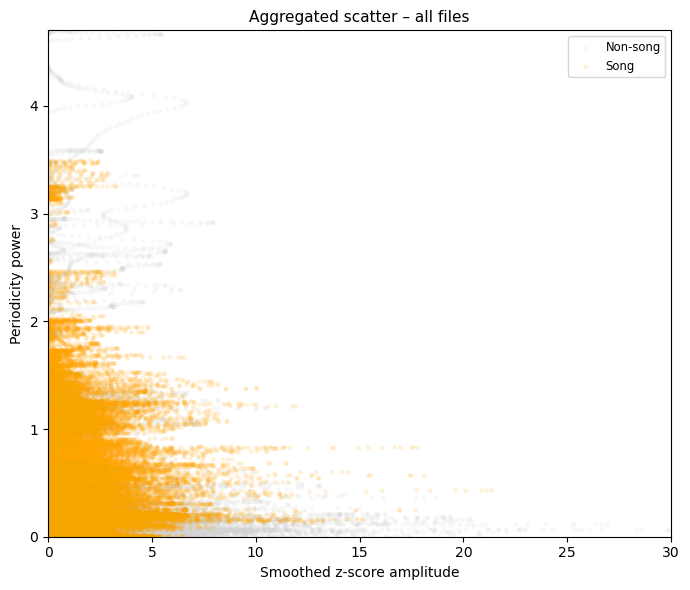

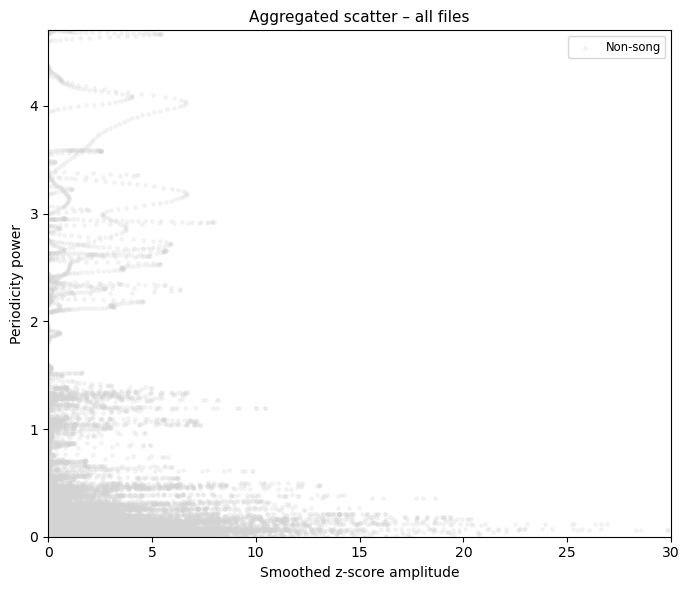

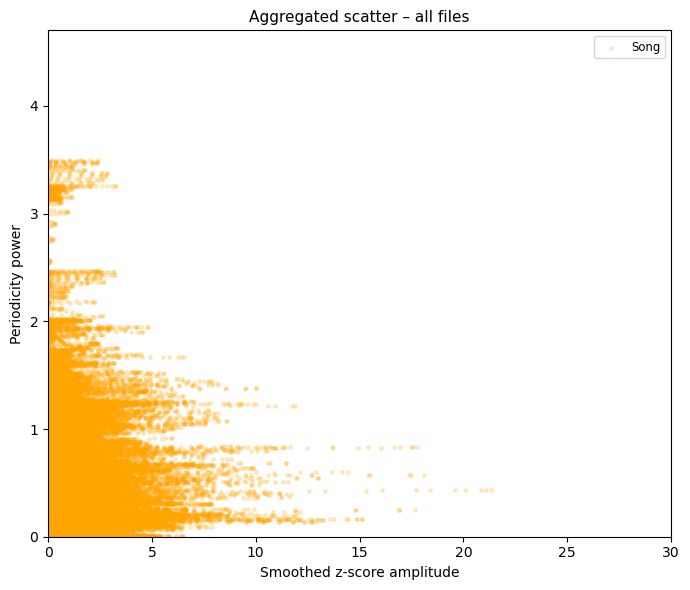

In [16]:
"""
Scatterplot: smoothed amplitude (x) vs periodicity power (y)
• Periodicity **interpolated onto the amplitude time‑base**  ← reversed!
• Points coloured by song / non‑song
• y‑axis limits identical across every per‑file plot (and pooled plot)

JSON expectations  (same as before):
    ─ z_amp_time & smoothed_z_amp   ··or··  log_amp_time & smoothed_log_amp
    ─ mod_band_time & mod_band_power ··or·· periodicity_time & periodicity
    ─ groundtruth_intervals / song_intervals  ← list[[start, stop], …] (sec)
"""

from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
JSON_PATH = Path(
    "/Volumes/my_own_SSD/UO_stuff/george_annotated_song/labeled_song_dataset/test_combined.json"
).expanduser().resolve()

records = json.loads(JSON_PATH.read_text(encoding="utf‑8"))
print(f"Loaded {len(records)} combined entries from {JSON_PATH.name}")

# ── helpers ─────────────────────────────────────────────────────────────────
def pick_amplitude(rec):
    if "z_amp_time" in rec and "smoothed_z_amp" in rec:
        return (np.asarray(rec["z_amp_time"],      dtype=float),
                np.asarray(rec["smoothed_z_amp"],  dtype=float),
                "Smoothed z‑score amplitude")
    if "log_amp_time" in rec and "smoothed_log_amp" in rec:
        return (np.asarray(rec["log_amp_time"],    dtype=float),
                np.asarray(rec["smoothed_log_amp"],dtype=float),
                "Smoothed log‑amplitude")
    return None, None, None

def pick_periodicity(rec):
    if "mod_band_time" in rec and "mod_band_power" in rec:
        return (np.asarray(rec["mod_band_time"],   dtype=float),
                np.asarray(rec["mod_band_power"],  dtype=float))
    if "periodicity_time" in rec and "periodicity" in rec:
        return (np.asarray(rec["periodicity_time"],dtype=float),
                np.asarray(rec["periodicity"],     dtype=float))
    return None, None

# ── first pass: compute arrays, collect y‑lims ──────────────────────────────
per_file = []                      # store data for second‑pass plotting
global_ymin, global_ymax = np.inf, -np.inf
all_x_song, all_y_song, all_x_non, all_y_non = [], [], [], []
x_label_final = None               # remember the label to reuse later

for rec in records:
    fname = rec.get("file_name", "unknown_file")

    t_amp, amp_vals, x_label = pick_amplitude(rec)
    t_per, per_vals          = pick_periodicity(rec)
    if t_amp is None or t_per is None or t_amp.size == 0 or t_per.size == 0:
        print(f"⚠️  {fname}: missing amplitude or periodicity – skipped")
        continue
    x_label_final = x_label

    # ── overlap range & interpolation (periodicity → amplitude grid) ────
    t0 = max(t_amp[0], t_per[0])
    t1 = min(t_amp[-1], t_per[-1])
    mask_amp = (t_amp >= t0) & (t_amp <= t1)
    if not mask_amp.any():
        print(f"⚠️  {fname}: no overlapping time span – skipped")
        continue

    amp_aligned = amp_vals[mask_amp]
    per_interp  = np.interp(t_amp[mask_amp], t_per, per_vals)

    # ── song mask on amplitude grid ────────────────────────────────────
    in_song = np.zeros_like(amp_aligned, dtype=bool)
    for start, stop in rec.get("groundtruth_intervals",
                               rec.get("song_intervals", [])):
        in_song |= (t_amp[mask_amp] >= float(start)) & (t_amp[mask_amp] <= float(stop))

    # ── collect stats for global y‑lim ─────────────────────────────────
    if per_interp.size:
        global_ymin = min(global_ymin, per_interp.min())
        global_ymax = max(global_ymax, per_interp.max())

    # ── stash per‑file data for later plotting ────────────────────────
    per_file.append({
        "file_name": fname,
        "x_song": amp_aligned[in_song],
        "y_song": per_interp[in_song],
        "x_non":  amp_aligned[~in_song],
        "y_non":  per_interp[~in_song],
    })

    # accumulate pooled arrays
    all_x_song.append(amp_aligned[in_song]);  all_y_song.append(per_interp[in_song])
    all_x_non.append(amp_aligned[~in_song]);  all_y_non.append(per_interp[~in_song])

# ── second pass: plot with unified y‑limits ─────────────────────────────────
# for rec in per_file:
#     plt.figure(figsize=(6, 5))
#     plt.scatter(rec["x_non"],  rec["y_non"],  s=8,  color="grey",
#                 alpha=0.2, label="Non‑song")
#     # plt.scatter(rec["x_song"], rec["y_song"], s=30, facecolor="yellow",
#     #             edgecolor="black", linewidth=0.5, alpha=0.9, label="Song")
#     plt.scatter(rec["x_song"], rec["y_song"], s=8, facecolor="orange", alpha=0.2, label="Song")
#     plt.xlabel(x_label_final)
#     plt.ylabel("Periodicity power")
#     plt.title(rec["file_name"], fontsize=9)
#     plt.ylim(global_ymin, global_ymax)
#     #plt.grid(True, lw=0.3, alpha=0.3)
#     plt.legend(fontsize="x-small")
#     plt.tight_layout()
#     plt.show()

# ── pooled scatter with same y‑lims ────────────────────────────────────────
if all_x_song:
    x_song = np.concatenate(all_x_song);  y_song = np.concatenate(all_y_song)
    x_non  = np.concatenate(all_x_non);   y_non  = np.concatenate(all_y_non)

    plt.figure(figsize=(7, 6))
    plt.scatter(x_non, y_non, s=6, color="lightgrey", alpha=0.1, label="Non‑song")
    plt.scatter(x_song, y_song, s=6, facecolor="orange", alpha=0.1, label="Song")
    plt.xlabel(x_label_final)
    plt.ylabel("Periodicity power")
    plt.title("Aggregated scatter – all files", fontsize=11)
    plt.ylim(global_ymin, global_ymax)
    plt.xlim(0, 30)
    #plt.grid(True, lw=0.3, alpha=0.3)
    plt.legend(fontsize="small")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 6))
    plt.scatter(x_non, y_non, s=6, color="lightgrey", alpha=0.2, label="Non‑song")
   #plt.scatter(x_song, y_song, s=6, facecolor="orange", alpha=0.2, label="Song")
    plt.xlabel(x_label_final)
    plt.ylabel("Periodicity power")
    plt.title("Aggregated scatter – all files", fontsize=11)
    plt.ylim(global_ymin, global_ymax)
    plt.xlim(0, 30)
    #plt.grid(True, lw=0.3, alpha=0.3)
    plt.legend(fontsize="small")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 6))
    #plt.scatter(x_non, y_non, s=6, color="lightgrey", alpha=0.2, label="Non‑song")
    plt.scatter(x_song, y_song, s=6, facecolor="orange", alpha=0.2, label="Song")
    plt.xlabel(x_label_final)
    plt.ylabel("Periodicity power")
    plt.title("Aggregated scatter – all files", fontsize=11)
    plt.ylim(global_ymin, global_ymax)
    plt.xlim(0, 30)
    #plt.grid(True, lw=0.3, alpha=0.3)
    plt.legend(fontsize="small")
    plt.tight_layout()
    plt.show()

else:
    print("No valid data to plot.")


## Periodicity vs. log amplitude:

In [ ]:
# import json
# import numpy as np
# import matplotlib.pyplot as plt
# from pathlib import Path

# # ──────────────────────────────────────────────────────────────
# # 1.  Path to the combined JSON
# COMBINED_JSON = Path(
#     "/Volumes/my_own_SSD/UO_stuff/george_annotated_song/labeled_song_dataset/test_combined.json"
# ).expanduser().resolve()

# # ──────────────────────────────────────────────────────────────
# # 2.  Load the records
# records = json.loads(COMBINED_JSON.read_text(encoding="utf‑8"))
# print(f"Loaded {len(records)} combined entries from {COMBINED_JSON.name}")

# # ──────────────────────────────────────────────────────────────
# # 3.  Prepare accumulators for the pooled plot
# all_x_song, all_y_song       = [], []
# all_x_nonsong, all_y_nonsong = [], []

# # ──────────────────────────────────────────────────────────────
# # 4.  Loop through segments: plot individually and collect points
# for rec in records:
#     fname      = rec["file_name"]
#     t_log      = np.asarray(rec["log_amp_time"],     dtype=float)
#     log_amp    = np.asarray(rec["smoothed_log_amp"], dtype=float)
#     t_mod      = np.asarray(rec["mod_band_time"],    dtype=float)
#     mod_pow    = np.asarray(rec["mod_band_power"],   dtype=float)

#     if t_log.size == 0 or t_mod.size == 0:
#         print(f"⚠️  {fname}: missing time axes – skipped")
#         continue

#     # ---- interpolate log‑amp onto the mod‑band grid ----
#     log_interp = np.interp(t_mod, t_log, log_amp)

#     # ---- ground‑truth mask ----
#     in_song = np.zeros_like(t_mod, dtype=bool)
#     for start, stop in rec["groundtruth_intervals"]:
#         in_song |= (t_mod >= start) & (t_mod <= stop)

#     # ---- collect points for pooled plot ----
#     all_x_song.append(log_interp[in_song])
#     all_y_song.append(mod_pow[in_song])
#     all_x_nonsong.append(log_interp[~in_song])
#     all_y_nonsong.append(mod_pow[~in_song])

#     # ---- per‑file scatter ----
#     plt.figure(figsize=(6, 5))
#     plt.scatter(log_interp[~in_song], mod_pow[~in_song],
#                 s=8, color="black", alpha=0.2, label="Non‑song")
#     # plt.scatter(log_interp[in_song],  mod_pow[in_song],
#     #             s=30, facecolor="yellow", edgecolor="black",
#     #             linewidth=0.5, alpha=0.2, label="Ground‑truth song")
#     plt.scatter(log_interp[in_song],  mod_pow[in_song],
#                 s=8, facecolor="orange", label="Ground‑truth song", alpha=0.2)
#     plt.xlabel("Smoothed log‑amplitude (interpolated)")
#     plt.ylabel("Periodicity power")
#     plt.title(fname, fontsize=9)
#     plt.grid(True, lw=0.3, alpha=0.3)
#     plt.legend(fontsize="x-small")
#     plt.tight_layout()
#     plt.show()

# # ──────────────────────────────────────────────────────────────
# # 5.  Make aggregated scatter‑plot
# if all_x_song:
#     # concatenate lists of arrays
#     x_song   = np.concatenate(all_x_song)
#     y_song   = np.concatenate(all_y_song)
#     x_non    = np.concatenate(all_x_nonsong)
#     y_non    = np.concatenate(all_y_nonsong)

#     plt.figure(figsize=(7, 6))
#     plt.scatter(x_non, y_non, s=6, color="black", alpha=0.1, label="Non‑song")
#     # plt.scatter(x_song, y_song, s=20, facecolor="yellow",
#     #             edgecolor="black", linewidth=0.4, alpha=0.2,
#     #             label="Ground‑truth song")
#     plt.scatter(x_song, y_song, s=6, facecolor="orange", alpha=0.1, label="Ground‑truth song")
#     plt.xlabel("Smoothed log‑amplitude (interpolated)")
#     plt.ylabel("Periodicity power")
#     plt.title("Aggregated scatter – all segments", fontsize=11)
#     plt.grid(True, lw=0.3, alpha=0.3)
#     plt.legend(fontsize="small")
#     plt.tight_layout()
#     plt.show()
# else:
#     print("No valid segments to pool.")
